In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# consts
PREV_CHAR_COUNT = 3

## Character mapping

In [2]:
# Denotes beginning and end
SPECIAL_CHAR = '.'
CHAR_TO_ID_STR = SPECIAL_CHAR + 'abcdefghijklmnopqrstuvwxyz'

char_to_id = {}
id_to_char = []

for i in range(len(CHAR_TO_ID_STR)):
    c = CHAR_TO_ID_STR[i]
    id_to_char.append(c)
    char_to_id[c] = i

NUM_CHAR = len(id_to_char)

## Load the text file

In [3]:
words = open('data/names.txt', 'r').read().splitlines()

In [4]:
len(words)

32033

## Word to labeled pairs

In [5]:
def word_to_labeled_pairs(word: str, prev_char_count: int, char_to_id):
    """
    Given a word (E.g. "emma") and prev_char_count, e.g. 3, return [xs,ys], the labeled data for learning.
    Conceptually, the returned xs, ys are like so:
    ... -> e
    ..e -> m
    .em -> m
    emm -> a
    mma -> .
    
    Each xs is an int array of size 3.
    Each ys is an int.
    char_to_id is in charge of mapping
    """
    xs = []
    ys = []
    expanded_word = [SPECIAL_CHAR] * prev_char_count + list(word) + [SPECIAL_CHAR]
    for left in range(len(word) + 1):
        xs.append([char_to_id[expanded_word[left + offset]] for offset in range(prev_char_count)])
        ys.append(char_to_id[expanded_word[left + prev_char_count]])
    return xs, ys


In [6]:
xs, ys = word_to_labeled_pairs("emma", PREV_CHAR_COUNT, char_to_id)
for i in range(len(ys)):
    print(f"{[id_to_char[x] for x in xs[i]]} -> {id_to_char[ys[i]]}")

['.', '.', '.'] -> e
['.', '.', 'e'] -> m
['.', 'e', 'm'] -> m
['e', 'm', 'm'] -> a
['m', 'm', 'a'] -> .


## Mini training data - just first 5 words

In [7]:
mini_x, mini_y = [], []
for word in words[:5]:
    xs, ys = word_to_labeled_pairs(word, PREV_CHAR_COUNT, char_to_id)
    mini_x.extend(xs)
    mini_y.extend(ys)
mini_x = torch.tensor(mini_x)
mini_y = torch.tensor(mini_y)

In [8]:
mini_x.shape, mini_x.dtype, mini_y.shape, mini_y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Model, loss function
- Input dim: (N,3) = (input size, num context word)
- Embed w/ size 2: (N, 6)
- FCC layer: tanh(W1x + b1): (N, 100)
- Compute logit: W2x + b2: (N, 27)
- Model is complete here!
- But for loss, we add cross-entropy against the Y's

In [9]:
# consts
N = len(mini_y)
EMBED_SIZE = 2
EMBED_CONCAT_VEC_SIZE = EMBED_SIZE * PREV_CHAR_COUNT
NUM_HIDDEN_NEURON = 100

In [10]:
# params
g = torch.Generator().manual_seed(2147483647)
embed = torch.randn((NUM_CHAR, EMBED_SIZE), generator = g)
w1 = torch.randn((EMBED_CONCAT_VEC_SIZE, NUM_HIDDEN_NEURON), generator = g)
b1 = torch.randn((NUM_HIDDEN_NEURON), generator = g)
w2 = torch.randn((NUM_HIDDEN_NEURON, NUM_CHAR), generator = g)
b2 = torch.randn((NUM_CHAR), generator = g)
params = [embed, w1, b1, w2, b2]

In [11]:
# model

# [LAYER] Embedding. 
# embed (27,2), mini_x (32,3) -> (32,3,2) -- do embedding lookup
x_looked_up = embed[mini_x]
assert x_looked_up.shape == (N, PREV_CHAR_COUNT, EMBED_SIZE)
x_looked_up_shaped = x_looked_up.view(N, EMBED_CONCAT_VEC_SIZE)
assert x_looked_up_shaped.shape == (N, EMBED_CONCAT_VEC_SIZE)

In [12]:
# [LAYER] FCC
fcc = (x_looked_up_shaped @ w1 + b1).tanh()
assert fcc.shape == (N, NUM_HIDDEN_NEURON)

In [13]:
# [LAYER] logit
logits = fcc @ w2 + b2

In [14]:
# [Loss layer]
loss = F.cross_entropy(logits, mini_y)

In [15]:
loss

tensor(17.7697)

## Train and overfit on mini data

In [16]:
lr = 0.1

g = torch.Generator().manual_seed(2147483647)
embed = torch.randn((NUM_CHAR, EMBED_SIZE), generator = g)
w1 = torch.randn((EMBED_CONCAT_VEC_SIZE, NUM_HIDDEN_NEURON), generator = g)
b1 = torch.randn((NUM_HIDDEN_NEURON), generator = g)
w2 = torch.randn((NUM_HIDDEN_NEURON, NUM_CHAR), generator = g)
b2 = torch.randn((NUM_CHAR), generator = g)
params = [embed, w1, b1, w2, b2]

for param in params:
    param.requires_grad = True

import pdb
def get_logits(xs):
    # xs = (num_data, 3)
    n = xs.shape[0]
    x_looked_up = embed[xs]
    x_looked_up_shaped = x_looked_up.view(n, EMBED_CONCAT_VEC_SIZE)
    fcc = (x_looked_up_shaped @ w1 + b1).tanh()
    logits = fcc @ w2 + b2
    return logits
    

In [17]:
for iter_i in range(1000):
    # fwd pass
    logits = get_logits(mini_x)
    loss = F.cross_entropy(logits, mini_y)
    
    if iter_i % 100 == 0:
        print(f"Loss @{iter_i}: {loss.data:.4f}")
    
    # bwd pass
    for param in params:
        param.grad = None
    loss.backward()

    # update
    for param in params:
        param.data -= lr * param.grad
    

Loss @0: 17.7697
Loss @100: 0.3354
Loss @200: 0.2789
Loss @300: 0.2679
Loss @400: 0.2632
Loss @500: 0.2636
Loss @600: 0.2602
Loss @700: 0.2586
Loss @800: 0.2576
Loss @900: 0.2568


## Sample

In [18]:
max_len = 20
num_sample = 10

def generate_sample(get_logits):
    word_so_far = [char_to_id[SPECIAL_CHAR]]*PREV_CHAR_COUNT
    while len(word_so_far) < max_len:
        input_tensor = torch.tensor([word_so_far[-PREV_CHAR_COUNT:]])
        logits = get_logits(input_tensor)
        probas = F.softmax(logits, dim = 1)
        next_char_id = torch.multinomial(probas[0], num_samples = 1, replacement=True).item()
        word_so_far.append(next_char_id)
        if id_to_char[next_char_id] == SPECIAL_CHAR:
            break
    return(''.join([id_to_char[ci] for ci in word_so_far])[PREV_CHAR_COUNT:-1])

for sample_i in range(num_sample):
    print(generate_sample(get_logits))

isabella
ava
sophia
olivia
ava
olivia
sophia
olivia
emma
emma


Hooray! We showed we can overfit on the training data

## Prepare real test splits

In [19]:
full_x, full_y = [], []
for word in words:
    xs, ys = word_to_labeled_pairs(word, PREV_CHAR_COUNT, char_to_id)
    full_x.extend(xs)
    full_y.extend(ys)
full_x = torch.tensor(full_x)
full_y = torch.tensor(full_y)

In [20]:
# split full_x and full_y into 80/10/10 train/val/test, but shuffle it first
N = len(full_y)
shuffled_indices = torch.randperm(N)
train_marker = int(0.8 * N)
val_marker = int(0.9 * N)
train_indices = shuffled_indices[:train_marker]
val_indices = shuffled_indices[train_marker:val_marker]
test_indices = shuffled_indices[val_marker:]

train_x = full_x[train_indices]
train_y = full_y[train_indices]
val_x = full_x[val_indices]
val_y = full_y[val_indices]
test_x = full_x[test_indices]
test_y = full_y[test_indices]

train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22815, 3]),
 torch.Size([22815]),
 torch.Size([22815, 3]),
 torch.Size([22815]))

## Train and show validation and train error

Loss @0: 24.5922
Loss @1000: 5.5981
Loss @2000: 4.3472
Loss @3000: 2.6753
Loss @4000: 2.7867
Loss @5000: 2.0421
Loss @6000: 2.2501
Loss @7000: 2.8016
Loss @8000: 2.5289
Loss @9000: 2.4519
Loss @10000: 2.4580
Loss @11000: 2.7677
Loss @12000: 2.8650
Loss @13000: 3.0491
Loss @14000: 3.0210
Loss @15000: 2.3792
Loss @16000: 2.6460
Loss @17000: 2.9550
Loss @18000: 2.5853
Loss @19000: 2.9805
Loss @20000: 2.7314
Loss @21000: 2.6928
Loss @22000: 2.2343
Loss @23000: 2.2573
Loss @24000: 2.6359
Loss @25000: 2.1737
Loss @26000: 2.3277
Loss @27000: 2.0560
Loss @28000: 2.4831
Loss @29000: 2.3575
Loss @30000: 2.0818
Loss @31000: 2.4756
Loss @32000: 2.4607
Loss @33000: 1.7771
Loss @34000: 2.6189
Loss @35000: 2.3927
Loss @36000: 2.7953
Loss @37000: 2.2228
Loss @38000: 2.0968
Loss @39000: 1.8706
Loss @40000: 2.3881
Loss @41000: 2.2503
Loss @42000: 2.0372
Loss @43000: 2.8200
Loss @44000: 2.4868
Loss @45000: 2.9676
Loss @46000: 2.3312
Loss @47000: 3.1335
Loss @48000: 2.1012
Loss @49000: 1.9464
Loss @50000:

Text(0, 0.5, 'loss')

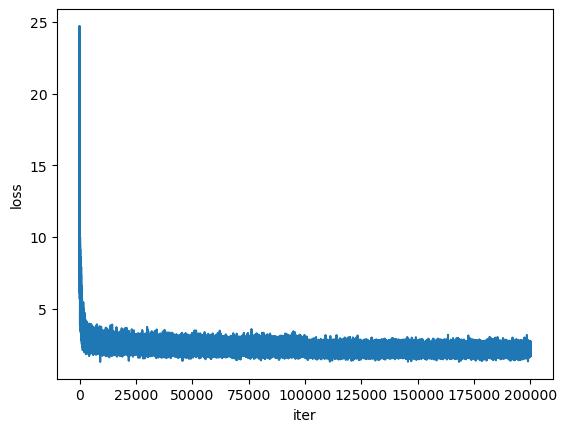

In [30]:
minibatch_size = 32
EMBED_SIZE = 10
EMBED_CONCAT_VEC_SIZE = EMBED_SIZE * PREV_CHAR_COUNT
NUM_HIDDEN_NEURON = 200

g = torch.Generator().manual_seed(2147483647)
embed = torch.randn((NUM_CHAR, EMBED_SIZE), generator = g)
w1 = torch.randn((EMBED_CONCAT_VEC_SIZE, NUM_HIDDEN_NEURON), generator = g)
b1 = torch.randn((NUM_HIDDEN_NEURON), generator = g)
w2 = torch.randn((NUM_HIDDEN_NEURON, NUM_CHAR), generator = g)
b2 = torch.randn((NUM_CHAR), generator = g)
params = [embed, w1, b1, w2, b2]

for param in params:
    param.requires_grad = True

def get_logits(xs):
    n = xs.shape[0]
    x_looked_up = embed[xs]
    x_looked_up_shaped = x_looked_up.view(n, EMBED_CONCAT_VEC_SIZE)
    fcc = (x_looked_up_shaped @ w1 + b1).tanh()
    logits = fcc @ w2 + b2
    return logits

train_losses = []
iters = []
for iter_i in range(200000):
    lr = 0.1 if iter_i < 100000 else 0.01
    # fwd pass
    # mini batch
    batch_indices = torch.randint(low = 0, high = len(train_y), size = (minibatch_size,))
    
    batch_x = train_x[batch_indices]
    batch_y = train_y[batch_indices]
    logits = get_logits(batch_x)
    loss = F.cross_entropy(logits, batch_y)
    
    if iter_i % 1000 == 0:
        print(f"Loss @{iter_i}: {loss.data:.4f}")
    
    # bwd pass
    for param in params:
        param.grad = None
    loss.backward()

    # update
    for param in params:
        param.data -= lr * param.grad
    train_losses.append(loss.data)
    iters.append(iter_i)

plt.plot(iters, train_losses)
plt.xlabel("iter")
plt.ylabel("loss")


In [31]:
logits = get_logits(val_x)
val_loss = F.cross_entropy(logits, val_y)
print(val_loss)

tensor(2.1587, grad_fn=<NllLossBackward0>)


In [37]:
for sample_i in range(20):
    print(generate_sample(get_logits))


assia
anclee
laedacee
janylaisee
rhelian
zhoann
raywendrett
chiah
kinsen
adre
angi
mavon
ala
able
pwe
van
atuston
adrice
joiriana
yan
